In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
!pip install country_converter
import country_converter as coco
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from tqdm import tqdm
from timeit import default_timer as timer
import shap
import warnings
warnings.filterwarnings("ignore")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.5 MB/s eta 0:00:00


---
## Loading Data

In [2]:
le_df = pd.read_csv('/kaggle/input/life-expectancy-who/Life Expectancy Data.csv')
cc = coco.CountryConverter()
le_df["continent"] = cc.convert(names=le_df["Country"], to='Continent')
le_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,continent
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,Asia
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,Asia
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,Asia
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,Asia
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,Asia


---
## EDA

In [3]:
le_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [4]:
le_df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


#### Convert Zero Values to NaN

In [5]:
le_df = le_df.replace(0, np.nan)

#### Get Rid of NaN Values

In [6]:
le_df = le_df.dropna(axis=0, thresh=17).reset_index(drop=True)
le_df.fillna(le_df.median(), inplace=True)
le_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2839 entries, 0 to 2838
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2839 non-null   object 
 1   Year                             2839 non-null   int64  
 2   Status                           2839 non-null   object 
 3   Life expectancy                  2839 non-null   float64
 4   Adult Mortality                  2839 non-null   float64
 5   infant deaths                    2839 non-null   float64
 6   Alcohol                          2839 non-null   float64
 7   percentage expenditure           2839 non-null   float64
 8   Hepatitis B                      2839 non-null   float64
 9   Measles                          2839 non-null   float64
 10   BMI                             2839 non-null   float64
 11  under-five deaths                2839 non-null   float64
 12  Polio               

In [7]:
le_df.groupby('Country').count()['Year'].sort_values()

Country
Palau                                     1
Dominica                                  1
Democratic People's Republic of Korea     3
Somalia                                   3
South Sudan                               4
                                         ..
Guinea-Bissau                            16
Guyana                                   16
Haiti                                    16
Georgia                                  16
Zimbabwe                                 16
Name: Year, Length: 184, dtype: int64

In [8]:
le_df.drop(le_df[le_df.Country == 'Palau'].index, axis=0, inplace=True)
le_df.drop(le_df[le_df.Country == 'Dominica'].index, axis=0, inplace=True)
country_column = le_df.Country

#### Encoding Categorical Columns

In [9]:
for categorical_column in ['Status', 'Country']:
    one_hot_encoded = pd.get_dummies(le_df[categorical_column], prefix=categorical_column, dtype=int)
    le_df = pd.concat([le_df, one_hot_encoded], axis=1)
    le_df.drop([categorical_column], axis=1, inplace=True)

le_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2837 entries, 0 to 2838
Columns: 205 entries, Year to Country_Zimbabwe
dtypes: float64(19), int64(185), object(1)
memory usage: 4.5+ MB


---
## Train & Test Data Preparation

#### Normalizing with min-max scaler

In [10]:
x_columns = le_df.drop(['Life expectancy ', 'continent'], axis=1).columns
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(le_df[x_columns])
le_df[x_columns] = scaled_df
le_df.head()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,...,Country_United Republic of Tanzania,Country_United States of America,Country_Uruguay,Country_Uzbekistan,Country_Vanuatu,Country_Venezuela (Bolivarian Republic of),Country_Viet Nam,Country_Yemen,Country_Zambia,Country_Zimbabwe
0,1.000000,65.0,0.362881,0.033908,0.0,0.003654,0.653061,0.005434,0.236292,0.032813,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.933333,59.9,0.373961,0.035019,0.0,0.003769,0.622449,0.002314,0.229765,0.034014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.866667,59.9,0.369806,0.036131,0.0,0.003754,0.642857,0.002022,0.223238,0.035214,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.800000,59.5,0.375346,0.037799,0.0,0.004008,0.673469,0.013130,0.216710,0.036815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.733333,59.2,0.379501,0.038911,0.0,0.000359,0.683673,0.014195,0.211488,0.038415,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Train & Test Splitting 

In [11]:
train_data, test_data = train_test_split(le_df, test_size=0.1, stratify=country_column)

In [12]:
train_data, test_data = train_data.reset_index(drop=True), test_data.reset_index(drop=True)

#### Dataloader Class

In [13]:
class MyDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        x = torch.tensor(sample.drop(['Life expectancy ', 'continent']).values.astype(float), dtype=torch.float32)
        y = torch.tensor(sample['Life expectancy '], dtype=torch.float32).unsqueeze(-1)
        return x, y

---
## Linear Regression

#### Model & Training Functions

In [14]:
class Linear_Model(nn.Module):
    def __init__(self, input_shape):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_features = input_shape, out_features = 128),
            nn.Linear(in_features = 128, out_features = 64),
            nn.Linear(in_features = 64, out_features = 1)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.layers(x)
        return x

#---------------------------------------------------------------------------------------------------------------------------------#
    
def train_step(model,
               data_loader,
               loss_fn,
               optimizer,
               device):
    
    # Send model to GPU
    model.to(device)
    train_loss, r2, counter = 0, 0, 0
    with tqdm(data_loader, desc ="  train") as train_tqdm:
        for X, y in train_tqdm:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            y_pred = model(X)

            # 2. Calculate loss
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()
            r2 += r2_score(y.cpu().detach(), y_pred.cpu().detach())
            counter += 1
            train_tqdm.set_postfix(loss=train_loss/counter, r2_score=r2/counter, refresh=True)

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

        # Calculate loss and accuracy per epoch and print out what's happening
        train_loss /= len(data_loader)
        
    return train_loss

#---------------------------------------------------------------------------------------------------------------------------------#

def test_step(model,
              data_loader,
              loss_fn,
              device):
    
    # Send model to GPU
    model.to(device)

    # put model in eval mode
    model.eval() 
    test_loss, r2, counter = 0, 0, 0
    with tqdm(data_loader, desc ="   test") as test_tqdm:
        for X, y in test_tqdm:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y).item()
            r2 += r2_score(y.cpu().detach(), test_pred.cpu().detach())
            counter += 1
            test_tqdm.set_postfix(loss=test_loss/counter, r2_score=r2/counter, refresh=True)

        # Adjust metrics and print out
        test_loss /= len(data_loader)
            
    return test_loss

#---------------------------------------------------------------------------------------------------------------------------------#

def Train(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs):
    
    train_epoch_loss = []
    test_epoch_loss = []

    train_time_start = timer()

    for epoch in range(epochs):
        print("EPOCH {}/{} :".format(epoch +1, epochs))
        train_loss = train_step(data_loader=train_dataloader,
                                model=model, 
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device
                               )
        test_loss = test_step(data_loader=test_dataloader,
                              model=model,
                              loss_fn=loss_fn,
                              device=device
                             )

        train_epoch_loss.append(train_loss)
        test_epoch_loss.append(test_loss)

    train_time_end = timer()
    total_time = train_time_end - train_time_start
    print(f"\n\nTrain time: {total_time:.3f} seconds")
    
    return train_epoch_loss, test_epoch_loss

#### Building Dataloaders, Model, Loos Function, Optimizer

In [15]:
train_dataset = MyDataset(train_data)
test_dataset = MyDataset(test_data)
train_dataloader = DataLoader(dataset = train_dataset, batch_size = 64, num_workers = 2, shuffle = True)
test_dataloader = DataLoader(dataset = test_dataset, batch_size = 64, num_workers = 2, shuffle = True)
model = Linear_Model(input_shape=203)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Training

In [16]:
train_epoch_loss, test_epoch_loss = Train(train_dataloader=train_dataloader,
                                          test_dataloader=test_dataloader,
                                          model=model,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          epochs=100)

EPOCH 1/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.86it/s, loss=2.96e+3, r2_score=-33.2]


EPOCH 2/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.87it/s, loss=128, r2_score=-.575]


EPOCH 3/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.46it/s, loss=42.2, r2_score=0.498]


EPOCH 4/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.25it/s, loss=34.6, r2_score=0.594]


EPOCH 5/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.83it/s, loss=28.1, r2_score=0.682]


EPOCH 6/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.06it/s, loss=23.7, r2_score=0.693]


EPOCH 7/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.51it/s, loss=22.1, r2_score=0.757]


EPOCH 8/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.60it/s, loss=19.3, r2_score=0.777]


EPOCH 9/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.29it/s, loss=18.1, r2_score=0.797]


EPOCH 10/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.64it/s, loss=17.2, r2_score=0.795]


EPOCH 11/100 :


   test: 100%|██████████| 5/5 [00:00<00:00,  8.02it/s, loss=15.6, r2_score=0.822]


EPOCH 12/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.42it/s, loss=16.2, r2_score=0.82] 


EPOCH 13/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.08it/s, loss=15.1, r2_score=0.838]


EPOCH 14/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 11.92it/s, loss=14.2, r2_score=0.842]


EPOCH 15/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.25it/s, loss=13.9, r2_score=0.84] 


EPOCH 16/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.09it/s, loss=13.3, r2_score=0.853]


EPOCH 17/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.88it/s, loss=12.5, r2_score=0.855]


EPOCH 18/100 :


   test: 100%|██████████| 5/5 [00:00<00:00,  7.80it/s, loss=12, r2_score=0.857]  


EPOCH 19/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.05it/s, loss=11.7, r2_score=0.866]


EPOCH 20/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.00it/s, loss=10.6, r2_score=0.881]


EPOCH 21/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.71it/s, loss=10.4, r2_score=0.881]


EPOCH 22/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 10.27it/s, loss=10.4, r2_score=0.884]


EPOCH 23/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.24it/s, loss=9.17, r2_score=0.896]


EPOCH 24/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.97it/s, loss=9.02, r2_score=0.897]


EPOCH 25/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 10.42it/s, loss=8.51, r2_score=0.903]


EPOCH 26/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.89it/s, loss=8.3, r2_score=0.906] 


EPOCH 27/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.48it/s, loss=7.82, r2_score=0.908]


EPOCH 28/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.72it/s, loss=7.84, r2_score=0.904]


EPOCH 29/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.05it/s, loss=7.35, r2_score=0.918]


EPOCH 30/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.37it/s, loss=6.72, r2_score=0.919]


EPOCH 31/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.89it/s, loss=7.17, r2_score=0.92] 


EPOCH 32/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.83it/s, loss=6.98, r2_score=0.922]


EPOCH 33/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.20it/s, loss=6.24, r2_score=0.929]


EPOCH 34/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 12.54it/s, loss=6.02, r2_score=0.933]


EPOCH 35/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.50it/s, loss=5.59, r2_score=0.935]


EPOCH 36/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.79it/s, loss=6, r2_score=0.929]   


EPOCH 37/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.75it/s, loss=5.82, r2_score=0.935]


EPOCH 38/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.12it/s, loss=5.57, r2_score=0.938]


EPOCH 39/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.81it/s, loss=4.98, r2_score=0.943]


EPOCH 40/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.81it/s, loss=5.34, r2_score=0.931]


EPOCH 41/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.83it/s, loss=5.09, r2_score=0.943]


EPOCH 42/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.27it/s, loss=5.78, r2_score=0.94] 


EPOCH 43/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 10.94it/s, loss=4.9, r2_score=0.939] 


EPOCH 44/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.12it/s, loss=5.32, r2_score=0.941]


EPOCH 45/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 11.21it/s, loss=4.86, r2_score=0.946]


EPOCH 46/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.46it/s, loss=5.14, r2_score=0.926]


EPOCH 47/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.02it/s, loss=4.84, r2_score=0.945]


EPOCH 48/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.97it/s, loss=5, r2_score=0.946]   


EPOCH 49/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.82it/s, loss=5.25, r2_score=0.941]


EPOCH 50/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 12.87it/s, loss=4.78, r2_score=0.947]


EPOCH 51/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.58it/s, loss=4.5, r2_score=0.948] 


EPOCH 52/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.86it/s, loss=4.44, r2_score=0.95] 


EPOCH 53/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.62it/s, loss=4.48, r2_score=0.949]


EPOCH 54/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.74it/s, loss=4.43, r2_score=0.947]


EPOCH 55/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.24it/s, loss=4.57, r2_score=0.951]


EPOCH 56/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.73it/s, loss=4.42, r2_score=0.946]


EPOCH 57/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.16it/s, loss=4.31, r2_score=0.951]


EPOCH 58/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.84it/s, loss=4.4, r2_score=0.949] 


EPOCH 59/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.82it/s, loss=4.28, r2_score=0.95] 


EPOCH 60/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.17it/s, loss=4.29, r2_score=0.952]


EPOCH 61/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.51it/s, loss=4.36, r2_score=0.952]


EPOCH 62/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.46it/s, loss=4.34, r2_score=0.951]


EPOCH 63/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.86it/s, loss=4.36, r2_score=0.947]


EPOCH 64/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.23it/s, loss=4.58, r2_score=0.946]


EPOCH 65/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.82it/s, loss=4.11, r2_score=0.95] 


EPOCH 66/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.46it/s, loss=4.37, r2_score=0.942]


EPOCH 67/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.15it/s, loss=4.2, r2_score=0.95]  


EPOCH 68/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 10.94it/s, loss=4.33, r2_score=0.948]


EPOCH 69/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 11.23it/s, loss=4.23, r2_score=0.953]


EPOCH 70/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.32it/s, loss=4.12, r2_score=0.954]


EPOCH 71/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.27it/s, loss=4.23, r2_score=0.949]


EPOCH 72/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.90it/s, loss=3.99, r2_score=0.952]


EPOCH 73/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.39it/s, loss=4.56, r2_score=0.95] 


EPOCH 74/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.79it/s, loss=4.38, r2_score=0.953]


EPOCH 75/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.82it/s, loss=4.09, r2_score=0.954]


EPOCH 76/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.07it/s, loss=4.69, r2_score=0.948]


EPOCH 77/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.36it/s, loss=4.05, r2_score=0.956]


EPOCH 78/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.29it/s, loss=4.05, r2_score=0.954]


EPOCH 79/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 12.36it/s, loss=4.22, r2_score=0.951]


EPOCH 80/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.06it/s, loss=4.25, r2_score=0.945]


EPOCH 81/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 10.03it/s, loss=4.18, r2_score=0.954]


EPOCH 82/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.10it/s, loss=4.09, r2_score=0.955]


EPOCH 83/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.19it/s, loss=4.41, r2_score=0.954]


EPOCH 84/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.71it/s, loss=4.26, r2_score=0.954]


EPOCH 85/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 12.27it/s, loss=4.14, r2_score=0.945]


EPOCH 86/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.93it/s, loss=4.11, r2_score=0.955]


EPOCH 87/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.47it/s, loss=4.69, r2_score=0.947]


EPOCH 88/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.87it/s, loss=4.05, r2_score=0.955]


EPOCH 89/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.56it/s, loss=3.94, r2_score=0.955]


EPOCH 90/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.30it/s, loss=3.8, r2_score=0.956] 


EPOCH 91/100 :


   test: 100%|██████████| 5/5 [00:00<00:00,  7.81it/s, loss=4.16, r2_score=0.951]


EPOCH 92/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.24it/s, loss=3.99, r2_score=0.954]


EPOCH 93/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.31it/s, loss=4.43, r2_score=0.953]


EPOCH 94/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.34it/s, loss=4.22, r2_score=0.954]


EPOCH 95/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.65it/s, loss=4.13, r2_score=0.951]


EPOCH 96/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.02it/s, loss=4.04, r2_score=0.953]


EPOCH 97/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.92it/s, loss=3.96, r2_score=0.953]


EPOCH 98/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 14.29it/s, loss=4.13, r2_score=0.954]


EPOCH 99/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.94it/s, loss=3.92, r2_score=0.955]


EPOCH 100/100 :


   test: 100%|██████████| 5/5 [00:00<00:00, 13.91it/s, loss=3.76, r2_score=0.957]



Train time: 283.714 seconds


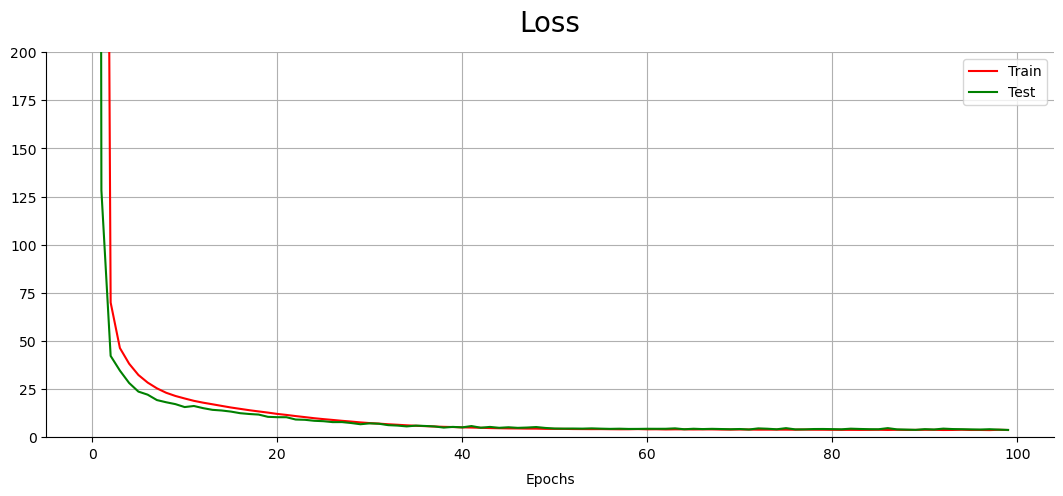

In [17]:
num_epochs = len(train_epoch_loss)
plt.figure(figsize=(13,5))
plt.plot(train_epoch_loss, 'r', label='Train')
plt.plot(test_epoch_loss , 'g', label='Test')
plt.xlabel('Epochs', fontsize=10, labelpad=8)
plt.title('Loss', fontsize=20, pad=15)
plt.ylim(0,200)
plt.grid()
plt.legend()
sns.despine()
plt.show();

---
## Summary Plots

#### Deep Explainer:

In [18]:
torch.set_grad_enabled(True)
X_test = torch.tensor(test_data.drop(['Life expectancy ', 'continent'], axis=1).values.astype(float), dtype=torch.float32)

In [19]:
deep_explainer = shap.DeepExplainer(model.cpu(), X_test)
deep_shap_values = deep_explainer.shap_values(X_test)

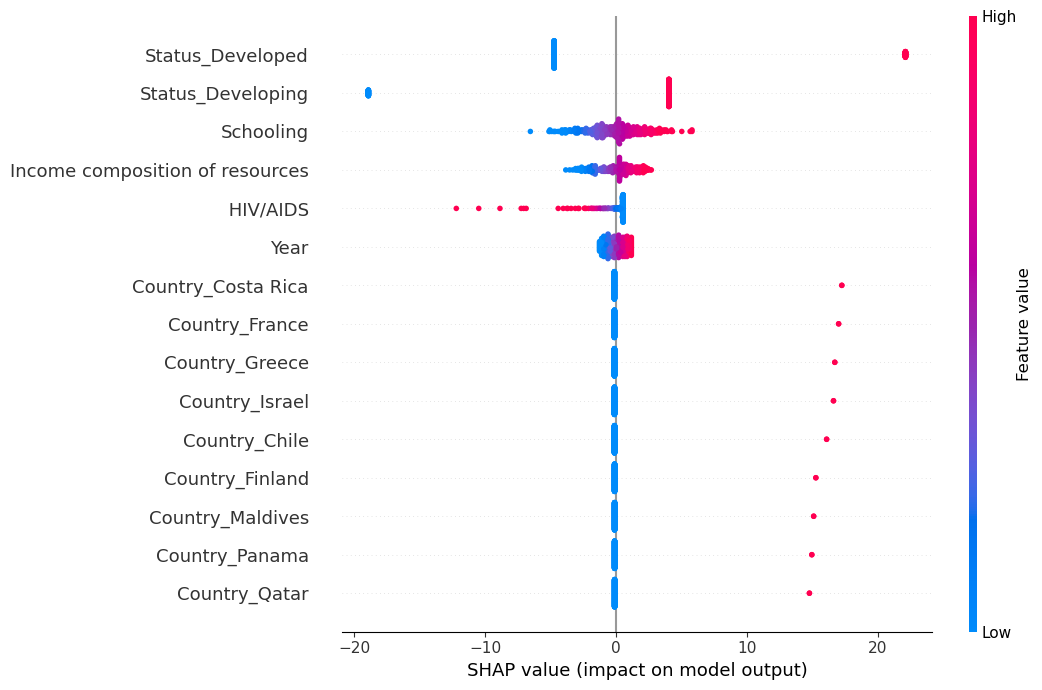

In [20]:
shap.summary_plot(deep_shap_values, features=X_test, feature_names=x_columns, max_display=15, plot_type='dot', plot_size=(11,7))

#### Kernel Explainer:

In [21]:
torch.set_grad_enabled(False)
X_test = test_data.drop(['Life expectancy ', 'continent'], axis=1).values.astype(float)
F = lambda x: model.cpu()( Variable( torch.tensor(x, dtype=torch.float32) ) ).detach().numpy()

In [22]:
kernel_explainer = shap.KernelExplainer(F, X_test)
kernel_shap_values = kernel_explainer.shap_values(X_test)

  0%|          | 0/284 [00:00<?, ?it/s]

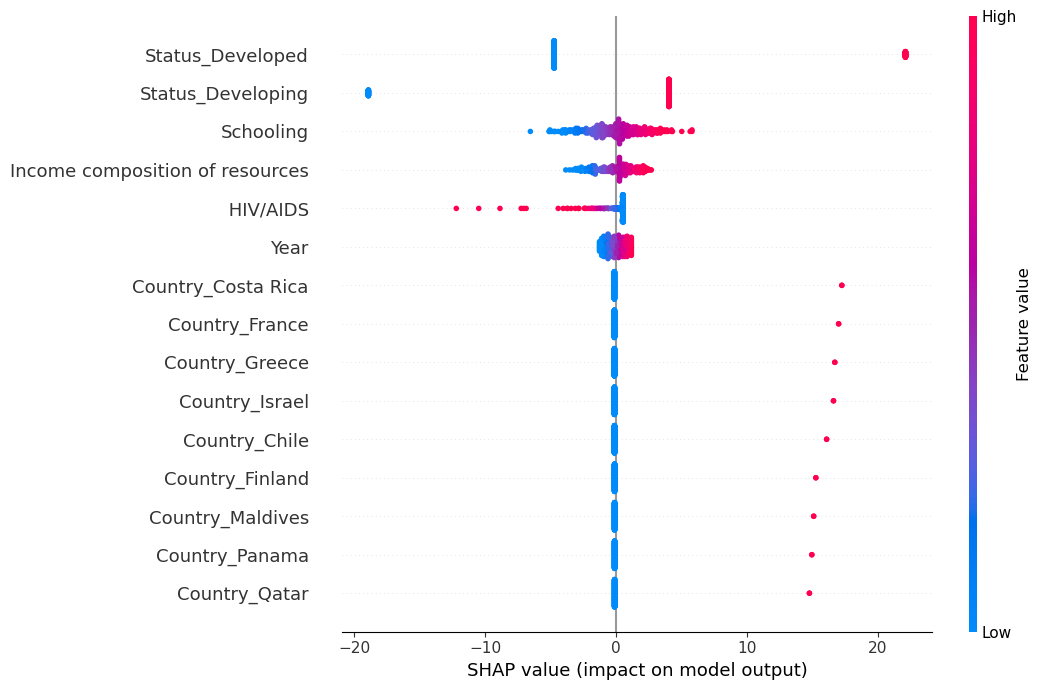

In [23]:
shap.summary_plot(kernel_shap_values[0], features=X_test, feature_names=x_columns, max_display=15, plot_type='dot', plot_size=(11,7))

---
## Force Plots

In [24]:
selected_df = test_data[test_data.continent == 'Europe'].sample(2)
one_cols = []
for col in selected_df.columns:
    if (selected_df[col] == 1).any():
        one_cols.append(col)

selected_inputs = selected_df.drop(['Life expectancy ', 'continent'], axis=1)
print("Columns with 1 values:", one_cols)

Columns with 1 values: ['Status_Developed', 'Country_Poland', 'Country_Romania']


#### Kernel Shap:

In [25]:
shap.initjs()
shap.force_plot(kernel_explainer.expected_value, kernel_shap_values[0][selected_inputs.index[0]], selected_inputs.iloc[0])

In [26]:
shap.initjs()
shap.force_plot(kernel_explainer.expected_value, kernel_shap_values[0][selected_inputs.index[1]], selected_inputs.iloc[1])

#### Deep Shap:

In [27]:
shap.initjs()
shap.force_plot(deep_explainer.expected_value, deep_shap_values[selected_inputs.index[0]], selected_inputs.iloc[0])

In [28]:
shap.initjs()
shap.force_plot(deep_explainer.expected_value, deep_shap_values[selected_inputs.index[1]], selected_inputs.iloc[1])

---

<div align=center lang="fa"><font face="Tahoma" size="5" color=#c4c4c4>End</font></div>

---